Meilleur coût total : 1592.04
Camion 1 : Chemin - Dépôt -> 20 -> 21 -> 27 -> 25 -> 28 -> 26 -> 23 -> 22 -> 5 -> 4 -> 3 -> 11 -> 8 -> Dépôt | Poids : 200
Camion 2 : Chemin - Dépôt -> 83 -> 84 -> 89 -> 88 -> 85 -> 95 -> 96 -> 100 -> 99 -> 97 -> Dépôt | Poids : 200
Camion 3 : Chemin - Dépôt -> 7 -> 6 -> 10 -> 79 -> 77 -> 73 -> 70 -> 71 -> 15 -> Dépôt | Poids : 170
Camion 4 : Chemin - Dépôt -> 62 -> 67 -> 65 -> 63 -> 61 -> 90 -> 86 -> 87 -> 9 -> 1 -> 2 -> Dépôt | Poids : 190
Camion 5 : Chemin - Dépôt -> 42 -> 44 -> 40 -> 43 -> 45 -> 46 -> 50 -> 51 -> 48 -> 52 -> 47 -> 49 -> 31 -> Dépôt | Poids : 170
Camion 6 : Chemin - Dépôt -> 69 -> 66 -> 59 -> 55 -> 57 -> 74 -> 64 -> 72 -> 60 -> 56 -> Dépôt | Poids : 200
Camion 7 : Chemin - Dépôt -> 41 -> 54 -> 53 -> 58 -> 37 -> 36 -> 39 -> 24 -> 17 -> Dépôt | Poids : 180
Camion 8 : Chemin - Dépôt -> 29 -> 68 -> 32 -> 35 -> 38 -> 33 -> 34 -> 94 -> 92 -> Dépôt | Poids : 180
Camion 9 : Chemin - Dépôt -> 75 -> 30 -> 18 -> 13 -> 14 -> 16 -> 12 -> 91 -> 98 ->

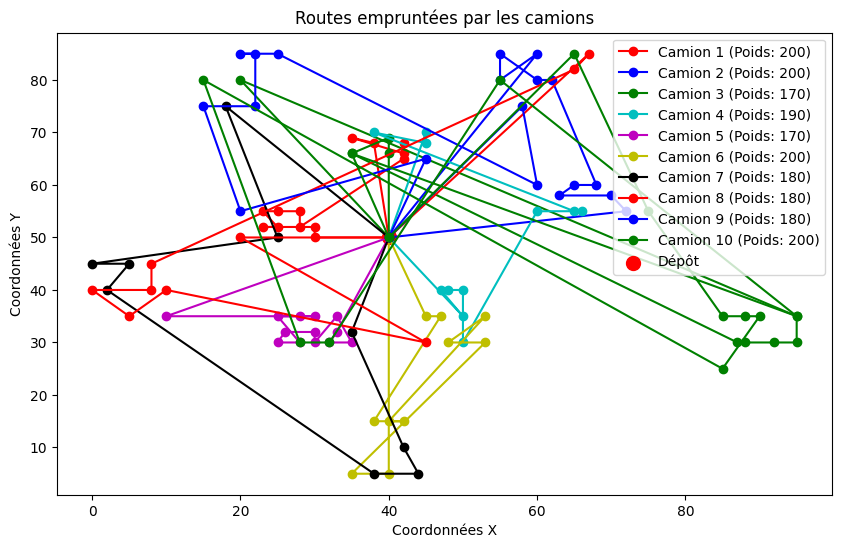

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
        max_vehicles = int(lines[vehicle_index + 2].split()[0])
        vehicle_capacity = int(lines[vehicle_index + 2].split()[1])

        customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
        depot_coords = None
        ready_time = None
        due_date = None
        customer_data = []

        for line in lines[customer_index + 2:]:
            data = line.strip().split()
            if len(data) == 7:
                customer_id = int(data[0])
                xcoord = float(data[1])
                ycoord = float(data[2])
                demand = int(data[3])
                ready_time_cust = int(data[4])
                due_date_cust = int(data[5])
                service_time = int(data[6])
                
                if customer_id == 0:
                    depot_coords = {'x': xcoord, 'y': ycoord}
                    ready_time = ready_time_cust
                    due_date = due_date_cust
                else:
                    customer_data.append({
                        'id': customer_id,
                        'x': xcoord,
                        'y': ycoord,
                        'demand': demand,
                        'ready_time': ready_time_cust,
                        'due_date': due_date_cust,
                        'service_time': service_time
                    })

        if depot_coords is None:
            raise ValueError("Coordonnées du dépôt manquantes ou incorrectes dans le fichier.")
        return depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data
    except Exception as e:
        print(f"An error occurred while parsing data: {e}")
        return None


# ACO Class
class AntColonyOptimization:
    def __init__(self, num_vehicles, vehicle_capacity, customer_data, depot_coords):
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_data = customer_data
        self.depot_coords = depot_coords
        self.distance_matrix = self.calculate_distance_matrix()
        self.pheromone = np.ones_like(self.distance_matrix)
        self.alpha = 1.0
        self.beta = 2.0
        self.best_solution = None
        self.best_cost = float('inf')

    def calculate_distance_matrix(self):
        num_customers = len(self.customer_data)
        matrix = np.zeros((num_customers + 1, num_customers + 1))
        for i in range(num_customers + 1):
            for j in range(i + 1, num_customers + 1):
                if i == 0:
                    dist = np.sqrt((self.depot_coords['x'] - self.customer_data[j-1]['x'])**2 +
                                   (self.depot_coords['y'] - self.customer_data[j-1]['y'])**2)
                elif j == 0:
                    dist = np.sqrt((self.depot_coords['x'] - self.customer_data[i-1]['x'])**2 +
                                   (self.depot_coords['y'] - self.customer_data[i-1]['y'])**2)
                else:
                    dist = np.sqrt((self.customer_data[i-1]['x'] - self.customer_data[j-1]['x'])**2 +
                                   (self.customer_data[i-1]['y'] - self.customer_data[j-1]['y'])**2)
                matrix[i, j] = matrix[j, i] = dist
        return matrix

    def choose_next_customer(self, visited, current_customer, truck_load):
        pheromone = self.pheromone[current_customer]
        pheromone[visited] = 0
        distance = self.distance_matrix[current_customer] + 1e-6
        probability = pheromone ** self.alpha * (1.0 / distance) ** self.beta

        if np.sum(probability) == 0:
            probability = np.ones_like(probability)
        probability /= np.sum(probability)

        next_customer = np.random.choice(range(len(self.customer_data) + 1), p=probability)
        if next_customer > 0:
            if truck_load + self.customer_data[next_customer-1]['demand'] <= self.vehicle_capacity:
                return next_customer
        return 0

    def simulate_ant(self):
        routes = []
        visited = [0]
        truck_load = 0
        total_distance = 0
        current_customer = 0

        while len(visited) < len(self.customer_data) + 1:
            route = []
            while True:
                next_customer = self.choose_next_customer(visited, current_customer, truck_load)
                if next_customer == 0:
                    break
                visited.append(next_customer)
                route.append(next_customer)
                truck_load += self.customer_data[next_customer-1]['demand']
                total_distance += self.distance_matrix[current_customer, next_customer]
                current_customer = next_customer
            if route:
                routes.append((route, truck_load, total_distance))
                truck_load = 0
                current_customer = 0
                total_distance += self.distance_matrix[current_customer, 0]
        return routes, round(total_distance, 2)

    def run(self, iterations=100):
        for _ in range(iterations):
            solution, total_cost = self.simulate_ant()
            if total_cost < self.best_cost:
                self.best_cost = total_cost
                self.best_solution = solution
        return self.best_solution, self.best_cost


# Plotting routes
def plot_routes(depot_coords, routes, customer_data):
    plt.figure(figsize=(10, 6))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']  # Predefined colors for up to 7 trucks
    for i, (route, truck_load, _) in enumerate(routes):
        color = colors[i % len(colors)]
        x = [depot_coords['x']] + [customer_data[customer-1]['x'] for customer in route] + [depot_coords['x']]
        y = [depot_coords['y']] + [customer_data[customer-1]['y'] for customer in route] + [depot_coords['y']]
        plt.plot(x, y, marker='o', label=f"Camion {i+1} (Poids: {truck_load})", color=color)
    plt.scatter(depot_coords['x'], depot_coords['y'], color='red', s=100, label="Dépôt")
    plt.xlabel("Coordonnées X")
    plt.ylabel("Coordonnées Y")
    plt.title("Routes empruntées par les camions")
    plt.legend()
    plt.show()


# Main Process
def main():
    file_path = "../dataset/c101.txt"
    data = parse_data(file_path)
    if data is None:
        return

    depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data = data
    aco = AntColonyOptimization(max_vehicles, vehicle_capacity, customer_data, depot_coords)
    best_solution, best_cost = aco.run()

    print(f"Meilleur coût total : {round(best_cost, 2)}")
    for i, (route, truck_load, _) in enumerate(best_solution):
        customer_ids = [customer_data[customer-1]['id'] for customer in route]
        print(f"Camion {i+1} : Chemin - Dépôt -> " + " -> ".join(map(str, customer_ids)) + f" -> Dépôt | Poids : {truck_load}")

    plot_routes(depot_coords, best_solution, customer_data)


if __name__ == "__main__":
    main()